Вспомогательные функции и Импорты

In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
def adf_test(timeseries, maxlag=None, regression='c', autolag='AIC'):
    '''
    regression='c' -> регрессия с константой
    AIC -> критерий Акаике
    BIC -> Байесовский критерий
    '''
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [3]:
def kpss_test(timeseries, maxlag='auto', regression='c'):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [4]:
def plot_forecast(df, fcast, model):
    fig, ax = plt.subplots(figsize=(15, 5))
    df.plot(ax=ax, legend=True)
    fcast['mean'].plot(ax=ax) # out-of-sample

    ax.fill_between(
        fcast.index, 
        fcast['mean_ci_lower'], 
        fcast['mean_ci_upper'], 
        color='k', 
        alpha=0.1
    ) 

    model.predict().plot(ax=ax, color='red', legend=True) # in-sample
    plt.show();

## Основная часть

In [5]:
df = pd.read_csv('variant2712.csv', sep=';', decimal=',')
df

,w,v,q
0,0.200898,0.803591,8.014130
1,-0.565659,-2.262637,8.003101
2,2.233380,-0.833036,5.973488
3,1.385686,-3.747280,5.191956
4,3.029379,-2.603950,4.615604
...,...,...,...
294,2.680523,-213.706234,3.839535
295,1.669260,-215.926995,4.444583
296,2.783687,-215.781501,4.525222
297,2.550734,-214.540925,4.401659


### Пункт а)

#### Стационарность

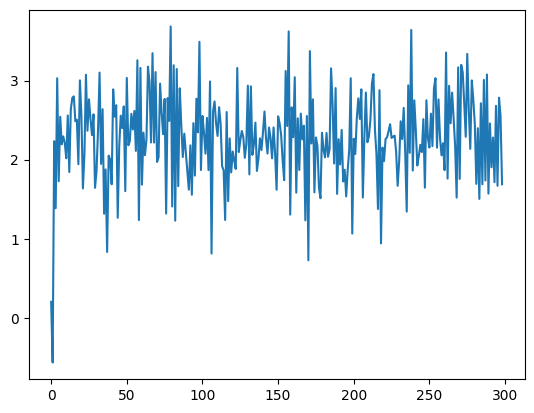

In [6]:
df.w.plot();

**Описание графика:** Мы видим, что в начальный момент времени ряд снижается, а потом резко вырастает выше первоначального значения, а дальше ряд колеблется вокруг примерно одного и того же значения по вертикальной оси, что может означать стационарность ряда. 

Проверим гипотезу о стационарности данного временного ряда формально:

In [7]:
adf_test(df.w, regression='c', autolag='BIC')

Results of Dickey-Fuller Test:
Test Statistic                -1.170195e+01
p-value                        1.561038e-21
#Lags Used                     1.000000e+00
Number of Observations Used    2.970000e+02
Critical Value (1%)           -3.452561e+00
Critical Value (5%)           -2.871321e+00
Critical Value (10%)          -2.571982e+00
dtype: float64


p-value теста на стационарность Дики-Фуллера с константой меньше люього разумного уровня значимости, что говорит об отвержении нулевой гипотезы:

$H_0$: ряд нестационарен (содержит единичный корень),  
$H_1$: ряд стационарен. 

Таким образом, ряд стационарен. 

In [8]:
kpss_test(df.w, regression='c')

Results of KPSS Test:
Test Statistic           0.184946
p-value                  0.100000
Lags Used                1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/var/folders/kn/wk_gspxn3dl6_5x56s3qj_c80000gn/T/ipykernel_14504/2337516338.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression=regression, nlags=maxlag)


У KPSS-теста гипотезы обратные (т.е. нулевая гипотеза соответствует стационарности ряда, а альтернативная &mdash; его нестационарности), поэтому при p-value > 0.10 заключаем, что нулевая гипотеза не отвергается и ряд стационарен

**Вывод:** Ряд стационарен. 

#### ACF и PACF

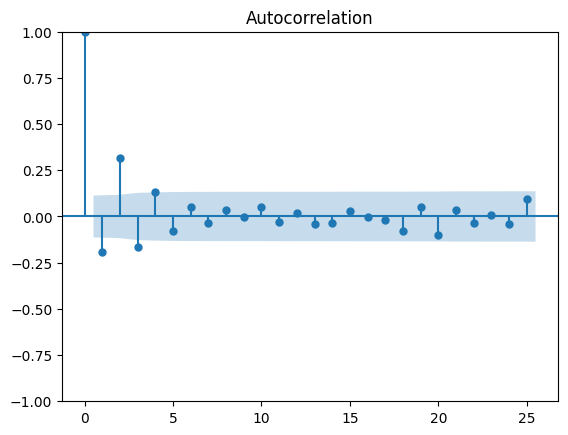

In [10]:
plot_acf(df.w);

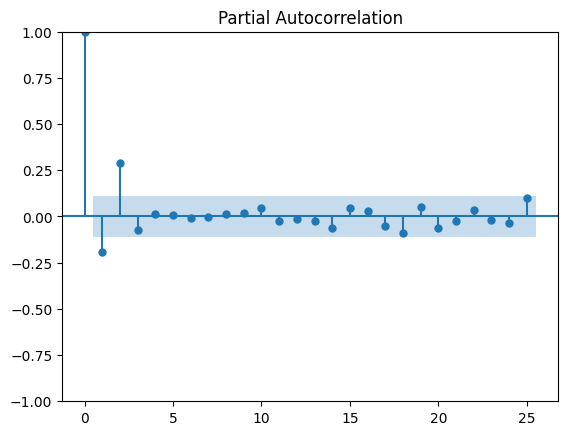

In [11]:
plot_pacf(df.w);

In [14]:
acf(df.w, nlags=6, alpha=0.05)
# смотрим только на первый np.array со значениями ACF

(array([ 1.        , -0.19106034,  0.31755359, -0.16450366,  0.13306182,
        -0.07697811,  0.05122079]),
 array([[ 1.        ,  1.        ],
        [-0.30440798, -0.07771269],
        [ 0.20014118,  0.43496599],
        [-0.29247555, -0.03653178],
        [ 0.00240135,  0.26372228],
        [-0.20936809,  0.05541186],
        [-0.08174299,  0.18418457]]))

In [15]:
pacf(df.w, nlags=6, alpha=0.05)

(array([ 1.        , -0.19170148,  0.29373722, -0.07564418,  0.01248737,
         0.01085044, -0.01089676]),
 array([[ 1.        ,  1.        ],
        [-0.30504912, -0.07835384],
        [ 0.18038958,  0.40708486],
        [-0.18899182,  0.03770346],
        [-0.10086027,  0.12583502],
        [-0.10249721,  0.12419808],
        [-0.12424441,  0.10245088]]))

Визуально видим, что для ACF значимы первые 3-4 лага (4-й лаг находится на границе доверительного интервала), а для PACF &mdash; первые 2. Отсюда следует, что:
1. возможно, мы имеем дело с ARMA-моделью
2. мы не будем рассматривать модели с лагами больших порядков



| **ACF**  |        |      |        |      |        |        |
| ---- | ------ | ---- | ------ | ---- | ------ | ------ |
| 1.   | \-0.19 | 0.32 | \-0.16 | 0.13 | \-0.08 | 0.05   |
|      |        |      |        |      |        |        |
| **PACF** |        |      |        |      |        |        |
| 1.   | \-0.19 | 0.29 | \-0.08 | 0.01 | 0.01   | \-0.01 |

<small>Таблица значений ACF и PACF, округленных до 2 знаков после запятой. </small>  
<small>Самый левый лаг &mdash; нулевой </small>

Теперь переберем модели ARIMA($\leq$ 4, 0, $\leq$ 4), чтобы выбрать лучшую среди них по двум параметрам:
1. Нормальность остатков <small>(если у нас есть две модели: у одной информационные критерии ниже, а у другой — остатки являются белым шумом, то выбирать надо вторую модель, даже если у неё информационные критерии ниже)</small>
2. Информационный критерий BIC. 

Ряд стационарный, поэтому все модели (..., 0, ...)

- **Ljung-Box** :

  - $H_0$ &mdash; остатки - белый шум

<br>

- **Heteroskedasticity** :

  - $H_0$ &mdash; остатки гомоскедастичны (тест Уайта)

<br>

- **Jarque-Bera** :

  - $H_0$ &mdash; остатки распределены нормально

In [38]:
print(
    ARIMA(df.w, order=(4, 0, 4), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 524.742

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -233.869
Date:                Wed, 27 Dec 2023   AIC                            487.738
Time:                        15:15:19   BIC                            524.742
Sample:                             0   HQIC                           502.549
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2699      0.036     62.377      0.000       2.199       2.341
ar.L1          0.2009      0.598      0.336      0.737      -0.972       1.374
ar.L2          0.0428      0.468      0.091      0.9

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
print(
    ARIMA(df.w, order=(4, 0, 3), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 516.782

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(4, 0, 3)   Log Likelihood                -232.739
Date:                Wed, 27 Dec 2023   AIC                            483.478
Time:                        15:15:43   BIC                            516.782
Sample:                             0   HQIC                           496.807
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2677      0.040     56.226      0.000       2.189       2.347
ar.L1         -0.5382      0.201     -2.679      0.007      -0.932      -0.144
ar.L2         -0.7203      0.142     -5.066      0.0

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
print(
    ARIMA(df.w, order=(4, 0, 2), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 513.748

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -234.072
Date:                Wed, 27 Dec 2023   AIC                            484.144
Time:                        14:44:40   BIC                            513.748
Sample:                             0   HQIC                           495.993
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2678      0.039     57.840      0.000       2.191       2.345
ar.L1         -0.1009      2.882     -0.035      0.972      -5.749       5.548
ar.L2          0.0041      1.337      0.003      0.9

In [19]:
print(
    ARIMA(df.w, order=(3, 0, 2), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 508.131

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -234.114
Date:                Wed, 27 Dec 2023   AIC                            482.228
Time:                        14:42:49   BIC                            508.131
Sample:                             0   HQIC                           492.596
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2683      0.039     58.596      0.000       2.192       2.344
ar.L1         -0.0584     12.100     -0.005      0.996     -23.773      23.656
ar.L2          0.3423      3.350      0.102      0.9

In [21]:
print(
    ARIMA(df.w, order=(3, 0, 1), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 502.425

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -234.111
Date:                Wed, 27 Dec 2023   AIC                            480.223
Time:                        14:45:21   BIC                            502.425
Sample:                             0   HQIC                           489.109
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2683      0.038     59.049      0.000       2.193       2.344
ar.L1         -0.1744      1.101     -0.158      0.874      -2.332       1.983
ar.L2          0.3096      0.138      2.242      0.0

In [ ]:
print(
    ARIMA(df.w, order=(3, 0, 0), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 502.416

In [22]:
print(
    ARIMA(df.w, order=(2, 0, 2), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 502.416

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -234.106
Date:                Wed, 27 Dec 2023   AIC                            480.213
Time:                        14:45:56   BIC                            502.416
Sample:                             0   HQIC                           489.099
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2684      0.038     59.264      0.000       2.193       2.343
ar.L1         -0.3008      0.237     -1.269      0.204      -0.765       0.164
ar.L2          0.2643      0.236      1.121      0.2

In [23]:
print(
    ARIMA(df.w, order=(2, 0, 1), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 496.739

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -234.118
Date:                Wed, 27 Dec 2023   AIC                            478.237
Time:                        14:47:03   BIC                            496.739
Sample:                             0   HQIC                           485.642
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2681      0.039     58.593      0.000       2.192       2.344
ar.L1         -0.2699      0.189     -1.428      0.153      -0.640       0.101
ar.L2          0.2999      0.076      3.925      0.0

In [24]:
print(
    ARIMA(df.w, order=(2, 0, 0), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 491.940

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -234.569
Date:                Wed, 27 Dec 2023   AIC                            477.139
Time:                        14:47:28   BIC                            491.940
Sample:                             0   HQIC                           483.063
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2668      0.041     55.609      0.000       2.187       2.347
ar.L1         -0.1126      0.037     -3.027      0.002      -0.186      -0.040
ar.L2          0.3312      0.063      5.300      0.0

In [25]:
print(
    ARIMA(df.w, order=(1, 0, 2), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 497.639

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -234.568
Date:                Wed, 27 Dec 2023   AIC                            479.137
Time:                        14:49:03   BIC                            497.639
Sample:                             0   HQIC                           486.542
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2703      0.035     64.813      0.000       2.202       2.339
ar.L1         -0.5781      0.147     -3.931      0.000      -0.866      -0.290
ma.L1          0.4742      0.159      2.986      0.0

In [26]:
print(
    ARIMA(df.w, order=(1, 0, 1), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 502.443

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -239.821
Date:                Wed, 27 Dec 2023   AIC                            487.641
Time:                        14:49:20   BIC                            502.443
Sample:                             0   HQIC                           493.566
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2729      0.030     76.375      0.000       2.215       2.331
ar.L1         -0.8126      0.105     -7.744      0.000      -1.018      -0.607
ma.L1          0.6244      0.132      4.740      0.0

In [27]:
print(
    ARIMA(df.w, order=(1, 0, 0), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 515.123

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -249.011
Date:                Wed, 27 Dec 2023   AIC                            504.022
Time:                        14:49:48   BIC                            515.123
Sample:                             0   HQIC                           508.465
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2743      0.029     79.576      0.000       2.218       2.330
ar.L1         -0.2001      0.046     -4.354      0.000      -0.290      -0.110
sigma2         0.3096      0.019     16.070      0.0

Результаты статистических тестов у всех моделей одинаковые, поэтому осуществим выбор модели по информационному критерию: наилучший он у модели ARIMA(2, 0, 0), поэтому остановимся на ней. 

**Вывод:** Далее будем рассматривать модель ARIMA(2, 0, 0). 

In [28]:
print(
    ARIMA(df.w, order=(2, 0, 0), trend='c')
    .fit()
    .summary()
)
# остатки - белый шум -> да
# остатки гомоскедастичны -> нет (на 5%)
# остатки распределены нормально -> нет
# BIC -> 491.940

                               SARIMAX Results                                
Dep. Variable:                      w   No. Observations:                  299
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -234.569
Date:                Wed, 27 Dec 2023   AIC                            477.139
Time:                        14:55:51   BIC                            491.940
Sample:                             0   HQIC                           483.063
                                - 299                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2668      0.041     55.609      0.000       2.187       2.347
ar.L1         -0.1126      0.037     -3.027      0.002      -0.186      -0.040
ar.L2          0.3312      0.063      5.300      0.0

<small> Уровень значимости по умолчанию: 5% </small>

$$
\widehat{y}_t = \underset{(0.041)^{***}}{2.2668} - \underset{(0.037)^{***}}{0.1126} y_{t-1} + \underset{(0.063)^{***}}{0.3312} y_{t-2}
$$

### Пункт б)

Будем строить прогноз на 1 период вперед

In [29]:
best_model = ARIMA(df.w, order=(2, 0, 0), trend='c').fit()
FC = best_model.get_forecast(steps=1)
FC.summary_frame()

w,mean,mean_se,mean_ci_lower,mean_ci_upper
299,2.425996,0.530004,1.387208,3.464784


**Прогноз на 1 период вперед:**

Прогнозное значение = 2.425996, ДИ = (1.387208, 3.464784)

### Пункт в)

In [33]:
df

,w,v,q
0,0.200898,0.803591,8.014130
1,-0.565659,-2.262637,8.003101
2,2.233380,-0.833036,5.973488
3,1.385686,-3.747280,5.191956
4,3.029379,-2.603950,4.615604
...,...,...,...
294,2.680523,-213.706234,3.839535
295,1.669260,-215.926995,4.444583
296,2.783687,-215.781501,4.525222
297,2.550734,-214.540925,4.401659


Здесь мы подберем наилучшую модель при помощи `auto_arima`

In [36]:
auto_arima(
    df.v, information_criterion='bic', return_valid_fits=True
)

(ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 1, 3), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 4), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 2), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 3), scoring_args={}, suppress_warnings=True,
       with_intercept=False),
 ARIMA(order=(1, 1, 4), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True),
 ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
       with_intercept=False))

In [37]:
auto_arima(
    df.v, information_criterion='bic'
).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -624.001
Date:                Wed, 27 Dec 2023   AIC                           1258.002
Time:                        15:10:42   BIC                           1276.488
Sample:                             0   HQIC                          1265.402
                                - 299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7379      0.186     -3.970      0.000      -1.102      -0.374
ma.L1          0.5396      0.057      9.505      0.000       0.428       0.651
ma.L2          0.3108      0.062      4.998      0.000       0.189       0.433
ma.L3         -0.2235      0.054     -4.112      0.000      -0.330      -0.117
sigma2         3.8468      0.341     11.283      0.000       3.179       4.515
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.70
Prob(Q):                              0.96   Prob(JB):                         0.70
Heteroskedasticity (H):               0.83   Skew:                             0.00
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Для ряда `v` наилучшей моделью оказалась ARIMA(0, 1, 3). 

Заметим, что все нулевые гипотезы ниже не отвергаются, то есть модель хорошая. 

- **Ljung-Box** :

  - $H_0$ &mdash; остатки - белый шум

<br>

- **Heteroskedasticity** :

  - $H_0$ &mdash; остатки гомоскедастичны (тест Уайта)

<br>

- **Jarque-Bera** :

  - $H_0$ &mdash; остатки распределены нормально

In [40]:
auto_arima(
    df.q, information_criterion='bic'
).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -214.437
Date:                Wed, 27 Dec 2023   AIC                            440.874
Time:                        15:17:18   BIC                            463.077
Sample:                             0   HQIC                           449.761
                                - 299                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6176      0.218      7.419      0.000       1.190       2.045
ar.L1          1.0246      0.118      8.654      0.000       0.793       1.257
ar.L2         -0.3844      0.099     -3.902      0.000      -0.577      -0.191
ma.L1          0.4596      0.123      3.744      0.000       0.219       0.700
ma.L2          0.3513      0.092      3.803      0.000       0.170       0.532
sigma2         0.2436      0.021     11.590      0.000       0.202       0.285
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 4.01
Prob(Q):                              0.87   Prob(JB):                         0.13
Heteroskedasticity (H):               0.94   Skew:                             0.28
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Для ряда `q` наилучшей моделью оказалась ARIMA(2, 0, 2). 

Заметим, что все нулевые гипотезы ниже не отвергаются, то есть модель хорошая. 

- **Ljung-Box** :

  - $H_0$ &mdash; остатки - белый шум

<br>

- **Heteroskedasticity** :

  - $H_0$ &mdash; остатки гомоскедастичны (тест Уайта)

<br>

- **Jarque-Bera** :

  - $H_0$ &mdash; остатки распределены нормально